In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.linear_model import SGDRegressor
from random import sample
from functools import lru_cache
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import random

from sklearn.datasets import make_classification
from sklearn.preprocessing import minmax_scale
from scipy.stats import truncnorm
from scipy.stats import skewnorm

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from utils import ServiceParams, vectorize_for_bonus_predict, vectorize_for_neighbours_predict, predict_neighbours, predict_bonus

import pickle
import zipfile

from collections import Counter

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

In [3]:
train_dataset_len = 20_000
test_dataset_len = 5000

(array([9.000e+00, 3.010e+02, 9.250e+02, 0.000e+00, 1.021e+03, 9.770e+02,
        9.900e+02, 0.000e+00, 9.780e+02, 9.230e+02, 0.000e+00, 9.010e+02,
        9.290e+02, 8.570e+02, 0.000e+00, 8.630e+02, 7.890e+02, 0.000e+00,
        7.670e+02, 7.830e+02, 6.870e+02, 0.000e+00, 6.760e+02, 5.870e+02,
        0.000e+00, 5.530e+02, 5.510e+02, 4.820e+02, 0.000e+00, 4.640e+02,
        4.100e+02, 3.960e+02, 0.000e+00, 3.790e+02, 3.120e+02, 0.000e+00,
        3.310e+02, 2.450e+02, 2.290e+02, 0.000e+00, 2.220e+02, 1.840e+02,
        0.000e+00, 1.550e+02, 1.720e+02, 1.280e+02, 0.000e+00, 1.140e+02,
        9.600e+01, 0.000e+00, 1.110e+02, 5.400e+01, 6.400e+01, 0.000e+00,
        6.000e+01, 4.800e+01, 4.100e+01, 0.000e+00, 3.500e+01, 2.600e+01,
        0.000e+00, 3.300e+01, 1.900e+01, 2.500e+01, 0.000e+00, 1.500e+01,
        2.700e+01, 0.000e+00, 8.000e+00, 1.300e+01, 6.000e+00, 0.000e+00,
        3.000e+00, 8.000e+00, 0.000e+00, 6.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+0

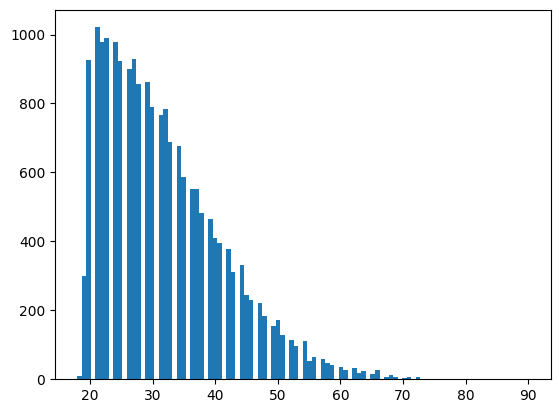

In [4]:
skewness = 30

age = skewnorm.rvs(a = skewness, size=train_dataset_len)
age = minmax_scale(age, feature_range=(18, 90))
age = age.round()
df_train = pd.DataFrame(age, columns=['age'])

age = skewnorm.rvs(a = skewness, size=test_dataset_len)
age = minmax_scale(age, feature_range=(18, 90))
age = age.round()
df_test = pd.DataFrame(age, columns=['age'])

plt.hist(df_train.age, bins=100)

In [5]:
# Service engage type
merchant_mcc_and_description = [
    "Electronics: Products such as smartphones, laptops, tablets, TVs, and gaming consoles",
    "Fashion: Clothing, shoes, handbags, accessories, and jewelry",
    "Beauty and personal care: Makeup, skincare, haircare, and grooming products",
    "Home and kitchen: Appliances, furniture, home decor, and cookware",
    "Sports and fitness: Athletic clothing, equipment, and supplements",
    "Toys and games: Board games, puzzles, action figures, and dolls",
    "Books and media: Fiction and non-fiction books, magazines, and DVDs",
    "Food and beverages: Snacks, drinks, and packaged foods",
    "Health and wellness: Vitamins, supplements, and medical devices",
    "Automotive: Cars, motorcycles, bicycles, and accessories",
    "Pet supplies: Products such as food, toys, and accessories for dogs, cats, and other pets",
    "Office supplies: Stationery, printers, and office furniture",
    "Music: Instruments, sheet music, and audio equipment",
    "Travel and leisure: Luggage, travel accessories, and camping gear",
    "Art and crafts: Supplies for drawing, painting, and crafting",
    "Garden and outdoor: Tools, planters, and outdoor furniture",
    "Baby and kids: Clothing, toys, and baby gear",
    "Industrial and scientific: Laboratory equipment, machinery, and scientific instruments",
    "Party supplies: Decorations, party favors, and supplies for hosting events",
    "Education and learning: Products such as textbooks, online courses, educational toys, and educational software for learners of all ages"
]

merchant_mcc = ['electronics',
 'fashion',
 'beauty and personal care',
 'home and kitchen',
 'sports and fitness',
 'toys and games',
 'books and media',
 'food and beverages',
 'health and wellness',
 'automotive',
 'pet supplies',
 'office supplies',
 'music',
 'travel and leisure',
 'art and crafts',
 'garden and outdoor',
 'baby and kids',
 'industrial and scientific',
 'party supplies',
 'education and learning']

bonus_type = [
    'welcome',
    'loyalty',
    'discount',
    'cashback',
    'up-sell',
    'small-gift',
    'big-gift',
    'early-access',
]

merchant_id_to_amount_range = {
    0: ['electronics', range(50, 10_000)],
    1: ['fashion', range(10, 10_000)],
    2: ['beauty and personal care', range(5, 500)],
    3: ['home and kitchen', range(10, 20_000)],
    4: ['sports and fitness', range(5, 5_000)],
    5: ['toys and games', range(5, 1000)],
    6: ['books and media', range(5, 1000)],
    7: ['food and beverages', range(1, 100)],
    8: ['health and wellness', range(5, 1000)],
    9: ['automotive', range(5_000, 100_000)],
    10: ['pet supplies', range(5, 1000)],
    11: ['office supplies', range(1, 10_000)],
    12: ['music', range(50, 10_000)],
    13: ['travel and leisure', range(50, 10_000)],
    14: ['art and crafts', range(5, 1000)],
    15: ['garden and outdoor', range(10, 20_000)],
    16: ['baby and kids', range(5, 1_000)],
    17: ['industrial and scientific', range(10, 100_000)],
    18: ['party supplies', range(5, 1_000)],
    19: ['education and learning', range(10, 10_000)]
 }

merchant_id_to_amount_range = {
    0: ['electronics', range(50, 10_000)],
    1: ['fashion', range(10, 10_000)],
    2: ['beauty and personal care', range(5, 500)],
    3: ['home and kitchen', range(10, 20_000)],
    4: ['sports and fitness', range(5, 5_000)],
    5: ['toys and games', range(5, 1000)],
    6: ['books and media', range(5, 1000)],
    7: ['food and beverages', range(1, 100)],
    8: ['health and wellness', range(5, 1000)],
    9: ['automotive', range(5_000, 100_000)],
    10: ['pet supplies', range(5, 1000)],
    11: ['office supplies', range(1, 10_000)],
    12: ['music', range(50, 10_000)],
    13: ['travel and leisure', range(50, 10_000)],
    14: ['art and crafts', range(5, 1000)],
    15: ['garden and outdoor', range(10, 20_000)],
    16: ['baby and kids', range(5, 1_000)],
    17: ['industrial and scientific', range(10, 100_000)],
    18: ['party supplies', range(5, 1_000)],
    19: ['education and learning', range(10, 10_000)]
 }

id2merchantName = { i : desc for i, desc in enumerate(merchant_mcc) }
merchantName2id = { desc : i for i, desc in enumerate(merchant_mcc) }
id2bonusName = { i : desc for i, desc in enumerate(bonus_type) }
bonusName2id = { desc : i for i, desc in enumerate(bonus_type) }
id2merchantName

{0: 'electronics',
 1: 'fashion',
 2: 'beauty and personal care',
 3: 'home and kitchen',
 4: 'sports and fitness',
 5: 'toys and games',
 6: 'books and media',
 7: 'food and beverages',
 8: 'health and wellness',
 9: 'automotive',
 10: 'pet supplies',
 11: 'office supplies',
 12: 'music',
 13: 'travel and leisure',
 14: 'art and crafts',
 15: 'garden and outdoor',
 16: 'baby and kids',
 17: 'industrial and scientific',
 18: 'party supplies',
 19: 'education and learning'}

In [6]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [7]:
number_of_stores = 1000
merchants_df = pd.DataFrame(index=range(0,number_of_stores), columns=['merchant_mcc', 'bonuses_available'])
def generate_random_stores(row):
    row['merchant_mcc'] = sample(merchant_mcc, 1)[0]
    row['bonuses_available'] = sample(bonus_type, random.randint(0, len(bonus_type)))
    return row
    
merchants_df = merchants_df.apply(generate_random_stores, axis=1)
merchants_df

,merchant_mcc,bonuses_available
0,home and kitchen,[]
1,health and wellness,"[cashback, loyalty, small-gift]"
2,home and kitchen,"[loyalty, up-sell, cashback, welcome, big-gift..."
3,baby and kids,[]
4,industrial and scientific,"[big-gift, loyalty, cashback]"
...,...,...
995,baby and kids,"[cashback, small-gift]"
996,fashion,"[big-gift, small-gift, up-sell, welcome, early..."
997,education and learning,[small-gift]
998,art and crafts,[]


In [41]:
# Purchase history generation {purchase_type, amount} random purchase_type, random amount
min_number_purchase = 0
max_number_purchase = 50
min_amount_bonus_points_available = 0
max_amount_bonus_points_available = 99_999_999
min_amount_assets_available = 0
max_amount_assets_available = 99_999_999
min_number_transactions = 0
max_number_transactions = 99_999_999

random_rating = get_truncated_normal(mean=10, sd=2, low=1, upp=5).rvs(train_dataset_len)

def generate_purchase_history(row, train=True):
    number_of_purchases = np.random.randint(min_number_purchase, max_number_purchase, 1)[0]
    purchase_preferences = np.random.randint(0, len(merchant_id_to_amount_range), 1)[0] 
    truncated_normal = get_truncated_normal(mean=purchase_preferences, sd=2, low=0, upp=len(merchant_id_to_amount_range)-1)
    indices = truncated_normal.rvs(number_of_purchases).round()
    current_merchant_id = random.randint(0, number_of_stores-1)
    current_merchant = merchants_df.iloc[current_merchant_id].copy()
    current_merchant_mcc = current_merchant.merchant_mcc
    bonuses_available = current_merchant.bonuses_available.copy()
    purchase_history = []
    purchase_history_names = []
    rating = random_rating[row.name]
    total_spending = 0
    for purchase_id in indices:
        purchase_name, range = merchant_id_to_amount_range[purchase_id]
        spending = np.around(np.random.uniform(range[0], range[-1]+1, 1), 1)[0]
        total_spending += spending
        purchase_history.append([purchase_name, spending])
        purchase_history_names.append(purchase_name)
    row['purchase_history'] = purchase_history
    row['rating'] = rating
    if train:
        purchase_history_names_count = Counter(purchase_history_names)
        row['current_merchant_id'] = current_merchant_id
        bonus_to_offer = ''
        if purchase_history_names_count.total() > 0:
            percentage_of_usage = purchase_history_names_count[current_merchant_mcc]*100/purchase_history_names_count.total()
        else:
            percentage_of_usage = 0
        if len(bonuses_available) > 0:
            if current_merchant_mcc not in purchase_history_names and 'welcome' in bonuses_available:
                if rating >= np.random.uniform(3.0, 5.0):
                    bonus_to_offer = 'welcome'
            elif total_spending >= 350_000.0 and 'up-sell' in bonuses_available:
                if rating >= np.random.uniform(1.0, 5.0):
                    bonus_to_offer = 'up-sell'
            elif percentage_of_usage >= 50.0 and 'big-gift' in bonuses_available:
                bonus_to_offer = 'big-gift'
            elif percentage_of_usage >= 30.0 and 'small-gift' in bonuses_available:
                if rating >= np.random.uniform(1.0, 5.0):
                    bonus_to_offer = 'small-gift'
            elif row.age > 65.0 and 'discount' in bonuses_available:
                if rating >= np.random.uniform(1.0, 5.0):
                    bonus_to_offer = 'discount'
            elif rating >= np.random.uniform(1.0, 5.0):
                if 'welcome' in bonuses_available: bonuses_available.remove('welcome')
                if 'up-sell' in bonuses_available: bonuses_available.remove('up-sell')
                if 'big-gift' in bonuses_available: bonuses_available.remove('big-gift')
                if bonuses_available:
                    bonus_to_offer = sample(bonuses_available, 1)[0]      
        row['bonus_to_offer'] = bonus_to_offer
        # row['total_spending'] = total_spending
    return row


df_train = df_train.apply(generate_purchase_history, axis = 1)
df_test = df_test.apply(generate_purchase_history, train=False, axis = 1)
df_train

,age,purchase_history,rating,current_merchant_id,bonus_to_offer
0,27.0,"[[garden and outdoor, 12772.9], [industrial an...",3.952476,554,
1,21.0,"[[pet supplies, 882.6], [music, 4702.2], [auto...",3.839845,225,small-gift
2,29.0,"[[health and wellness, 601.6], [toys and games...",4.843120,699,
3,44.0,"[[home and kitchen, 7127.1], [health and welln...",3.825687,617,
4,24.0,"[[office supplies, 1006.8], [automotive, 34318...",4.822571,942,small-gift
...,...,...,...,...,...
19995,26.0,"[[party supplies, 894.6], [party supplies, 687...",4.058890,353,up-sell
19996,41.0,"[[toys and games, 811.8], [home and kitchen, 1...",4.517523,919,discount
19997,26.0,"[[automotive, 90115.1]]",4.936572,674,welcome
19998,47.0,"[[travel and leisure, 7725.8], [office supplie...",4.784696,593,welcome


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(1, 0, 'welcome'),
  Text(2, 0, 'small-gift'),
  Text(3, 0, 'cashback'),
  Text(4, 0, 'early-access'),
  Text(5, 0, 'discount'),
  Text(6, 0, 'loyalty'),
  Text(7, 0, 'up-sell'),
  Text(8, 0, 'big-gift')])

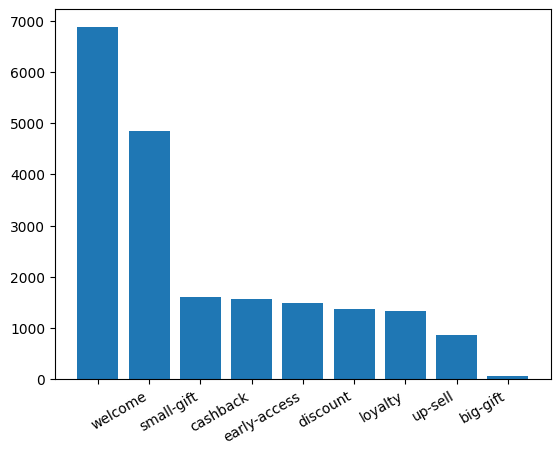

In [42]:
bonuses_distribution = df_train.bonus_to_offer.value_counts()
bonuses_distribution
plt.bar(bonuses_distribution.index, bonuses_distribution.values)
plt.xticks(rotation=30, ha='right')


In [10]:
merchants_counts = merchants_df.merchant_mcc.value_counts()
merchants_counts/merchants_counts.sum()

beauty and personal care     0.066
home and kitchen             0.058
automotive                   0.057
industrial and scientific    0.057
health and wellness          0.054
education and learning       0.054
food and beverages           0.052
pet supplies                 0.051
baby and kids                0.051
party supplies               0.050
travel and leisure           0.050
books and media              0.048
sports and fitness           0.047
art and crafts               0.046
toys and games               0.046
office supplies              0.046
fashion                      0.043
music                        0.042
garden and outdoor           0.042
electronics                  0.040
Name: merchant_mcc, dtype: float64

In [11]:
# w = w / (sum(w in marked_points))


# sports and fitness           0.063
# pet supplies                 0.051
# music                        0.036

# sports and fitness    4
# sports and fitness    3
# pet supplies          5
# pet supplies          5
# pet supplies          2
# music                 5

# w(sports and fitness) = w(sports and fitness)/sum(w(sports and fitness), w(pet supplies), w(music))

# sports and fitness           0,42
# pet supplies                 0,34
# music                        0,24

# sum((mean(category))*w(category))
# ((4+3)/2)*0,42+((5+5+2)/3)*0,34+((5)/1)*0,24

In [12]:
service_params = ServiceParams(
    max_number_purchase = max_number_purchase,
    bonus_type = bonus_type,
    merchantName2id = merchantName2id,
    bonusName2id = bonusName2id,
)

In [43]:
vectors =  np.array(df_train.apply(vectorize_for_bonus_predict, merchant_id=None, merchants_db=merchants_df, params=service_params, axis=1).to_list())
X = vectors[:,:-1].astype(np.float32)
y = vectors[:,-1].astype(np.int32)
X, y, X.shape, y.shape

(array([[27.       ,  0.       ,  0.       , ...,  1.       ,  1.       ,
          3.952476 ],
        [21.       ,  0.       ,  0.       , ...,  1.       ,  1.       ,
          3.839845 ],
        [29.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          4.8431196],
        ...,
        [26.       ,  0.       ,  0.       , ...,  1.       ,  0.       ,
          4.936572 ],
        [47.       ,  0.       ,  0.       , ...,  0.       ,  1.       ,
          4.7846966],
        [45.       ,  0.       ,  0.       , ...,  1.       ,  1.       ,
          3.5656471]], dtype=float32),
 array([-1,  5, -1, ...,  0,  0, -1], dtype=int32),
 (20000, 31),
 (20000,))

In [44]:
# gbc_clf = GradientBoostingClassifier(verbose=1, random_state=SEED)
gbc_clf = RandomForestClassifier(verbose=1, random_state=SEED)

pipeline  = Pipeline([
        # ('scaler', StandardScaler()), 
        ('ereg',  gbc_clf)
        ])

pipeline.fit(X, y)
pipeline.score(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


1.0

In [80]:
predict_bonus(client_id=396, store_id=210, rating=4.7, model=pipeline, client_database=df_test, merchant_database=merchants_df, service_params=service_params)

/home/evigurskiy/workspace/PythonProjects/bnb_ml/utils.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_record.rating = rating
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


('up-sell', 0.64)

In [81]:
vectors =  np.array(df_train.apply(vectorize_for_neighbours_predict, params=service_params, axis=1).to_list())
X = vectors.astype(np.float32)
X

array([[2.7000000e+01, 1.6000000e+01, 1.2772900e+04, ..., 0.0000000e+00,
        0.0000000e+00, 3.9524760e+00],
       [2.1000000e+01, 1.1000000e+01, 8.8259998e+02, ..., 0.0000000e+00,
        0.0000000e+00, 3.8398449e+00],
       [2.9000000e+01, 9.0000000e+00, 6.0159998e+02, ..., 0.0000000e+00,
        0.0000000e+00, 4.8431196e+00],
       ...,
       [2.6000000e+01, 1.0000000e+01, 9.0115102e+04, ..., 0.0000000e+00,
        0.0000000e+00, 4.9365721e+00],
       [4.7000000e+01, 1.4000000e+01, 7.7257998e+03, ..., 0.0000000e+00,
        0.0000000e+00, 4.7846966e+00],
       [4.5000000e+01, 1.7000000e+01, 4.1420001e+02, ..., 0.0000000e+00,
        0.0000000e+00, 3.5656471e+00]], dtype=float32)

In [82]:
nbrs_clf = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nbrs_clf.fit(X)

NearestNeighbors(algorithm='ball_tree')

In [18]:
distances, indices = nbrs_clf.kneighbors(X[:1])
nearest = df_train.iloc[indices[0]]
nearest, distances

(        age                                   purchase_history    rating  \
 0      27.0  [[home and kitchen, 5663.1], [books and media,...  1.798534   
 19412  29.0  [[books and media, 91.5], [food and beverages,...  3.091755   
 15618  59.0  [[office supplies, 168.5], [baby and kids, 556...  4.971579   
 1786   24.0  [[office supplies, 8536.7], [garden and outdoo...  4.233227   
 16755  35.0  [[art and crafts, 405.6], [garden and outdoor,...  4.942804   
 
        current_merchant_id bonus_to_offer  
 0                      293       discount  
 19412                  585                 
 15618                  900                 
 1786                   948     small-gift  
 16755                  706     small-gift  ,
 array([[    0.        , 30459.40786348, 45896.20196259, 46671.9393344 ,
         47516.02130805]]))

In [19]:
predict_neighbours(8, nbrs_clf, df_test, service_params)

(array([1222, 1687, 2891]), array([0.96292167, 0.9605202 , 0.9559736 ]))

In [20]:
# Import models and data for inference
from os.path import basename

gbc_filename = 'data/gbc.clf'
nbrs_filename = 'data/nbrs.clf'
service_params_filename = 'data/service.params'
pickle.dump(gbc_clf, open(gbc_filename, 'wb'))
pickle.dump(nbrs_clf, open(nbrs_filename, 'wb'))
pickle.dump(service_params, open(service_params_filename, 'wb'))
df_train.to_csv('data/train_db.csv', index=False)
df_test.to_csv('data/test_db.csv', index=False)
merchants_df.to_csv('data/merchants_db.csv', index=False)
with zipfile.ZipFile('data/gbc.zip', 'w') as zip:
    zip.write(gbc_filename, arcname=basename(gbc_filename), compress_type=zipfile.ZIP_DEFLATED)
with zipfile.ZipFile('data/nbrs.zip', 'w') as zip:
    zip.write(nbrs_filename, arcname=basename(nbrs_filename), compress_type=zipfile.ZIP_DEFLATED)